# Omission Power Correlation

Brief 1-2 sentence description of notebook.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import glob
from collections import defaultdict
import re

In [3]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import itertools
from scipy.stats import linregress

In [4]:
import spikeinterface.extractors as se
import spikeinterface.preprocessing as sp
from spectral_connectivity import Multitaper, Connectivity
import spectral_connectivity

## Inputs & Data

Explanation of each input and where it comes from.

In [5]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

In [6]:
BBOX_TO_ANCHOR=(1.5, 0.9)
LOC='upper right'

In [7]:
ALL_BANDS = ["theta", "beta", "gamma"]
BAND_TO_FREQ = {"theta": {"low_freq": 4, "high_freq": 12}, "beta": {"low_freq": 13, "high_freq": 30}, "gamma": {"low_freq": 30, "high_freq": 70}}

In [8]:
# variables for LFP extraction
FREQ_MIN=0.5
FREQ_MAX=300
NOTCH_FREQ=60
ORIGINAL_SAMPLE_RATE = 20000
RESAMPLE_RATE=1000
TRIAL_DURATION=10

In [9]:
INPUT_VARIABLE = 1

TIME_HALFBANDWIDTH_PRODUCT = 2
TIME_WINDOW_DURATION = 3
TIME_WINDOW_STEP = 1.5 

TRIAL_TIME_STAMP_DURATION = 1000*10

In [10]:
BIN_TO_COLOR = {0: {"baseline": "lightblue", "trial": "blue"}, 1: {"baseline": "lightgreen", "trial": "green"}, 2: {"baseline": "lightcoral", "trial": "red"}}
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}
BIN_TO_VELOCITY = {0: "0 to 2.5cm/s", 1: "2.5 to 5cm/s", 2: "5cm/s+"}

In [11]:
NUM_LINES = 3

In [12]:
# Generate colors from the "Blues" colormap
LOSING_COLORS = cm.Oranges(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
WINNING_COLORS = cm.Blues(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
REWARDED_COLORS = cm.Greens(np.linspace(0.5, 1, NUM_LINES))
# Generate colors from the "Blues" colormap
OMISSION_COLORS = cm.Reds(np.linspace(0.5, 1, NUM_LINES))

In [27]:
BASELINE_OUTCOME_TO_COLOR = {'lose': "orange",
'lose_baseline': LOSING_COLORS[0],
'omission': "red",
'omission_baseline': "hotpink",
'rewarded': "green",
'rewarded_baseline': REWARDED_COLORS[0],
'win': "blue",
'win_baseline': WINNING_COLORS[0],
'lose_comp': "orange", 
'lose_non_comp': "yellow",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [14]:
BASELINE_OUTCOME_TO_COLOR = {'lose_trial': "orange",
 'lose_baseline': LOSING_COLORS[0],
 'omission_trial': "red",
 'omission_baseline': "hotpink",
 'rewarded_trial': "green",
 'rewarded_baseline': REWARDED_COLORS[0],
 'win_trial': "blue",
 'win_baseline': WINNING_COLORS[0]}

In [15]:
COMPETITIVE_OUTCOME_TO_COLOR = {'lose_comp': "orange", 
'lose_non_comp': "yellow",
'omission': "red",
'rewarded': "green",
'win_comp': "blue", 
'win_non_comp': WINNING_COLORS[0]}

In [16]:
TRIAL_OR_BASELINE_TO_STYLE = {'baseline': "--", "trial": "-"}

In [17]:
CHANNEL_MAPPING_DF = pd.read_excel("../../channel_mapping.xlsx")
CHANNEL_MAPPING_DF["Subject"] = CHANNEL_MAPPING_DF["Subject"].astype(str)

TONE_TIMESTAMP_DF = pd.read_excel("../../rce_tone_timestamp.xlsx", index_col=0)
OUTPUT_DIR = r"./proc" # where data is saved should always be shown in the inputs


In [18]:
FULL_LFP_TRACES = pd.read_pickle("./proc/full_baseline_and_trial_lfp_traces.pkl")

In [19]:
FULL_LFP_TRACES = FULL_LFP_TRACES.drop_duplicates(subset=["recording_file", "time"], keep="first")

In [20]:
GROUPINGS = "competition_closeness"


## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

- Ideally functions are defined here first and then data is processed using the functions
    - function names are short and in snake case all lowercase
    - a function name should be unique but does not have to describe the function
    - doc strings describe functions not function names

In [21]:
def generate_pairs(lst):
    pairs = []
    n = len(lst)
    for i in range(n):
        for j in range(i+1, n):
            pairs.append((lst[i], lst[j]))
    return pairs

In [22]:
def nested_dict():
    return defaultdict(dict)

triple_nested_dict = defaultdict(nested_dict)

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [23]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

## Power calculation for each trial for each brain region

In [25]:
trace_columns = [col for col in FULL_LFP_TRACES.columns if "trace" in col]

In [26]:
trace_columns

['mPFC_baseline_lfp_trace',
 'mPFC_trial_lfp_trace',
 'vHPC_baseline_lfp_trace',
 'vHPC_trial_lfp_trace',
 'BLA_baseline_lfp_trace',
 'BLA_trial_lfp_trace',
 'LH_baseline_lfp_trace',
 'LH_trial_lfp_trace',
 'MD_baseline_lfp_trace',
 'MD_trial_lfp_trace']

In [32]:
for region in trace_columns:
    region_base_name = "{}".format("_".join(region.split("_")[:2]))
    print(region_base_name)
    # Getting the multitaper from each brain region
    multitaper_col = "{}_multitaper".format(region_base_name)
    FULL_LFP_TRACES[multitaper_col] = FULL_LFP_TRACES[region].apply(lambda x: Multitaper(time_series=x, sampling_frequency=RESAMPLE_RATE))
    # Getting the connectivity from each brain region, 
    # which has the power for the trace
    connectivity_col = "{}_connectivity".format(region_base_name)
    FULL_LFP_TRACES[connectivity_col] = FULL_LFP_TRACES[multitaper_col].apply(lambda x: Connectivity.from_multitaper(x))
    FULL_LFP_TRACES["{}_power".format(region_base_name)] = FULL_LFP_TRACES[connectivity_col].apply(lambda x: x.power().squeeze())
    # Getting the frequencies for each power
    FULL_LFP_TRACES["{}_frequencies".format(region_base_name)] = FULL_LFP_TRACES[connectivity_col].apply(lambda x: x.frequencies)

mPFC_baseline
mPFC_trial
vHPC_baseline
vHPC_trial
BLA_baseline
BLA_trial
LH_baseline
LH_trial
MD_baseline
MD_trial


- Averaging the powers for each band

In [34]:
ALL_BANDS

['theta', 'beta', 'gamma']

In [35]:
BAND_TO_FREQ

{'theta': {'low_freq': 4, 'high_freq': 12},
 'beta': {'low_freq': 13, 'high_freq': 30},
 'gamma': {'low_freq': 30, 'high_freq': 70}}

In [117]:
FULL_LFP_TRACES["BLA_trial_frequencies"].iloc[0][BAND_TO_FREQ["theta"]["low_freq"]*10]

4.0

In [121]:
FULL_LFP_TRACES["BLA_trial_frequencies"].iloc[0][BAND_TO_FREQ["theta"]["high_freq"]*10+1]

12.100000000000001

In [37]:
for region in trace_columns:    
    region_base_name = "{}".format("_".join(region.split("_")[:2]))
    print(region_base_name)
    
    for band in ALL_BANDS:
        FULL_LFP_TRACES["{}_averaged_{}_power".format(region_base_name, band)] = FULL_LFP_TRACES["{}_power".format(region_base_name)].apply(lambda x: np.mean(x[BAND_TO_FREQ[band]["low_freq"]*10:BAND_TO_FREQ[band]["high_freq"]*10+1]))

        


mPFC_baseline
mPFC_trial
vHPC_baseline
vHPC_trial
BLA_baseline
BLA_trial
LH_baseline
LH_trial
MD_baseline
MD_trial


In [45]:
FULL_LFP_TRACES["BLA_baseline_averaged_theta_power"].mean()

0.02474309971118351

In [ ]:
raise ValueError()

In [137]:
print("hello")

hello


## Power correlation between brain regions calculation

- Combining the trial/baseline and outcome label for coloring

- Filtering out the outliers

In [57]:
band_averaged_columns

['mPFC_baseline_averaged_gamma_power',
 'mPFC_trial_averaged_gamma_power',
 'vHPC_baseline_averaged_gamma_power',
 'vHPC_trial_averaged_gamma_power',
 'BLA_baseline_averaged_gamma_power',
 'BLA_trial_averaged_gamma_power',
 'LH_baseline_averaged_gamma_power',
 'LH_trial_averaged_gamma_power',
 'MD_baseline_averaged_gamma_power',
 'MD_trial_averaged_gamma_power']

In [138]:
from scipy.stats import zscore

In [139]:
band_averaged_columns = [col for col in FULL_LFP_TRACES.columns if "averaged".format(band) in col]

# Removing rows that are outliers
filtered_df = FULL_LFP_TRACES.copy()

filtered_df = filtered_df[(np.abs(zscore(filtered_df[band_averaged_columns])) <= 2).all(axis=1)].copy()

- Plotting all of the conditions

In [140]:
filtered_df.head()

time                                      recording_dir  \
1   6909411  20230617_115521_standard_comp_to_omission_D1_s...   
2   9209413  20230617_115521_standard_comp_to_omission_D1_s...   
3  11009410  20230617_115521_standard_comp_to_omission_D1_s...   
4  12109413  20230617_115521_standard_comp_to_omission_D1_s...   
5  13109412  20230617_115521_standard_comp_to_omission_D1_s...   

                                      recording_file  time_stamp_index  \
1  20230617_115521_standard_comp_to_omission_D1_s...           3430878   
2  20230617_115521_standard_comp_to_omission_D1_s...           5730880   
3  20230617_115521_standard_comp_to_omission_D1_s...           7530877   
4  20230617_115521_standard_comp_to_omission_D1_s...           8630880   
5  20230617_115521_standard_comp_to_omission_D1_s...           9630879   

                                          video_file  video_frame  \
1  20230617_115521_standard_comp_to_omission_D1_s...         3425   
2  20230617_115521_standard_comp_to_omission_D1_s...         5720   
3  20230617_115521_standard_comp_to_omission_D1_s...         7516   
4  20230617_115521_standard_comp_to_omission_D1_s...         8615   
5  20230617_115521_standard_comp_to_omission_D1_s...         9612   

   video_number    subject_info competition_closeness  \
1           1.0  1-1_t1b3L_box1              win_comp   
2           1.0  1-1_t1b3L_box1              win_comp   
3           1.0  1-1_t1b3L_box1         lose_non_comp   
4           1.0  1-1_t1b3L_box1          win_non_comp   
5           1.0  1-1_t1b3L_box1              win_comp   

                                          video_name  ...  \
1  20230617_115521_standard_comp_to_omission_D1_s...  ...   
2  20230617_115521_standard_comp_to_omission_D1_s...  ...   
3  20230617_115521_standard_comp_to_omission_D1_s...  ...   
4  20230617_115521_standard_comp_to_omission_D1_s...  ...   
5  20230617_115521_standard_comp_to_omission_D1_s...  ...   

  LH_baseline_averaged_gamma_power LH_trial_averaged_theta_power  \
1                         0.001062                      0.057460   
2                         0.001088                      0.045500   
3                         0.001046                      0.053668   
4                         0.001090                      0.033430   
5                         0.001180                      0.038939   

  LH_trial_averaged_beta_power  LH_trial_averaged_gamma_power  \
1                     0.004720                       0.001343   
2                     0.004495                       0.001217   
3                     0.004353                       0.001128   
4                     0.004615                       0.001077   
5                     0.004322                       0.001146   

  MD_baseline_averaged_theta_power MD_baseline_averaged_beta_power  \
1                         0.045300                        0.003236   
2                         0.031699                        0.003201   
3                         0.031489                        0.002840   
4                         0.051877                        0.003607   
5                         0.044914                        0.004289   

  MD_baseline_averaged_gamma_power MD_trial_averaged_theta_power  \
1                         0.000894                      0.054819   
2                         0.000938                      0.045314   
3                         0.000864                      0.051407   
4                         0.000970                      0.037664   
5                         0.001014                      0.041086   

  MD_trial_averaged_beta_power MD_trial_averaged_gamma_power  
1                     0.004346                      0.001164  
2                     0.003965                      0.001015  
3                     0.004041                      0.000959  
4                     0.003794                      0.000913  
5                     0.003876                      0.000940  

[5 rows x 110 columns]

In [141]:
filtered_df

time                                      recording_dir  \
1     6909411  20230617_115521_standard_comp_to_omission_D1_s...   
2     9209413  20230617_115521_standard_comp_to_omission_D1_s...   
3    11009410  20230617_115521_standard_comp_to_omission_D1_s...   
4    12109413  20230617_115521_standard_comp_to_omission_D1_s...   
5    13109412  20230617_115521_standard_comp_to_omission_D1_s...   
..        ...                                                ...   
405  64081824  20230621_111240_standard_comp_to_omission_D5_s...   
406  65281838  20230621_111240_standard_comp_to_omission_D5_s...   
407  66781856  20230621_111240_standard_comp_to_omission_D5_s...   
408  68781880  20230621_111240_standard_comp_to_omission_D5_s...   
409  70681909  20230621_111240_standard_comp_to_omission_D5_s...   

                                        recording_file  time_stamp_index  \
1    20230617_115521_standard_comp_to_omission_D1_s...           3430878   
2    20230617_115521_standard_comp_to_omission_D1_s...           5730880   
3    20230617_115521_standard_comp_to_omission_D1_s...           7530877   
4    20230617_115521_standard_comp_to_omission_D1_s...           8630880   
5    20230617_115521_standard_comp_to_omission_D1_s...           9630879   
..                                                 ...               ...   
405  20230621_111240_standard_comp_to_omission_D5_s...          60888780   
406  20230621_111240_standard_comp_to_omission_D5_s...          62088794   
407  20230621_111240_standard_comp_to_omission_D5_s...          63588812   
408  20230621_111240_standard_comp_to_omission_D5_s...          65588836   
409  20230621_111240_standard_comp_to_omission_D5_s...          67488865   

                                            video_file  video_frame  \
1    20230617_115521_standard_comp_to_omission_D1_s...         3425   
2    20230617_115521_standard_comp_to_omission_D1_s...         5720   
3    20230617_115521_standard_comp_to_omission_D1_s...         7516   
4    20230617_115521_standard_comp_to_omission_D1_s...         8615   
5    20230617_115521_standard_comp_to_omission_D1_s...         9612   
..                                                 ...          ...   
405  20230621_111240_standard_comp_to_omission_D5_s...        60859   
406  20230621_111240_standard_comp_to_omission_D5_s...        62056   
407  20230621_111240_standard_comp_to_omission_D5_s...        63554   
408  20230621_111240_standard_comp_to_omission_D5_s...        65550   
409  20230621_111240_standard_comp_to_omission_D5_s...        67447   

     video_number    subject_info competition_closeness  \
1             1.0  1-1_t1b3L_box1              win_comp   
2             1.0  1-1_t1b3L_box1              win_comp   
3             1.0  1-1_t1b3L_box1         lose_non_comp   
4             1.0  1-1_t1b3L_box1          win_non_comp   
5             1.0  1-1_t1b3L_box1              win_comp   
..            ...             ...                   ...   
405           1.0  1-4_t3b3L_box1              rewarded   
406           1.0  1-4_t3b3L_box1              rewarded   
407           1.0  1-4_t3b3L_box1              rewarded   
408           1.0  1-4_t3b3L_box1              rewarded   
409           1.0  1-4_t3b3L_box1              omission   

                                            video_name  ...  \
1    20230617_115521_standard_comp_to_omission_D1_s...  ...   
2    20230617_115521_standard_comp_to_omission_D1_s...  ...   
3    20230617_115521_standard_comp_to_omission_D1_s...  ...   
4    20230617_115521_standard_comp_to_omission_D1_s...  ...   
5    20230617_115521_standard_comp_to_omission_D1_s...  ...   
..                                                 ...  ...   
405  20230621_111240_standard_comp_to_omission_D5_s...  ...   
406  20230621_111240_standard_comp_to_omission_D5_s...  ...   
407  20230621_111240_standard_comp_to_omission_D5_s...  ...   
408  20230621_111240_standard_comp_to_omission_D5_s...  ...   
409  20230621_111240_sta

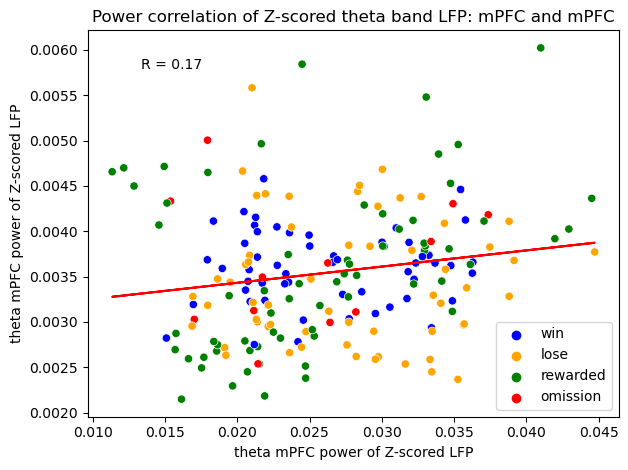

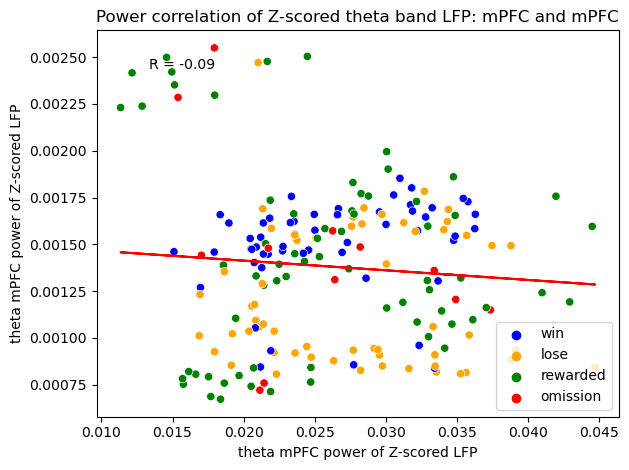

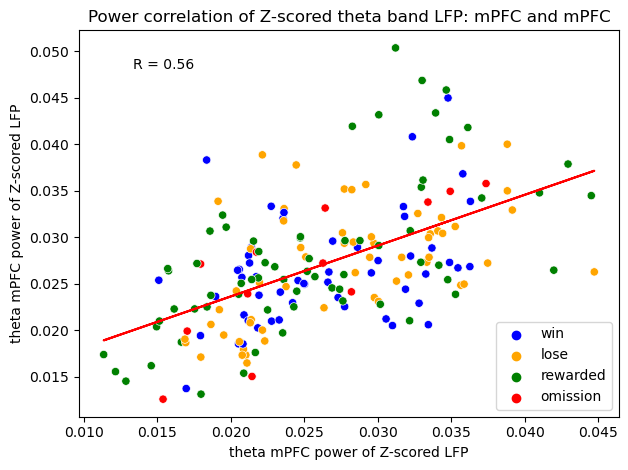

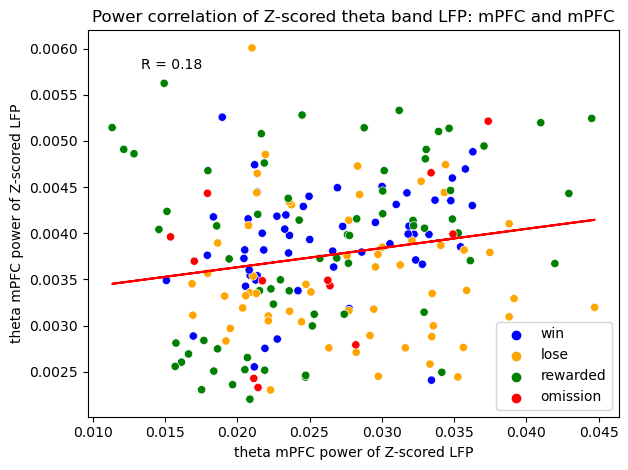

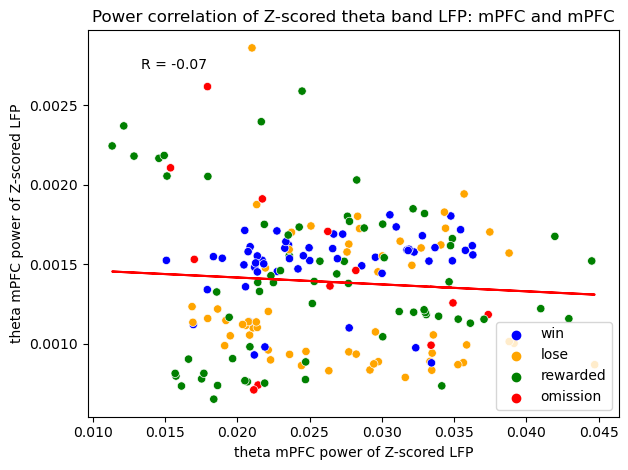

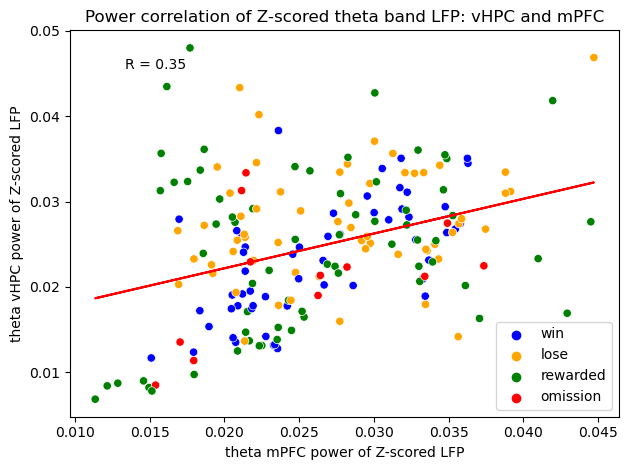

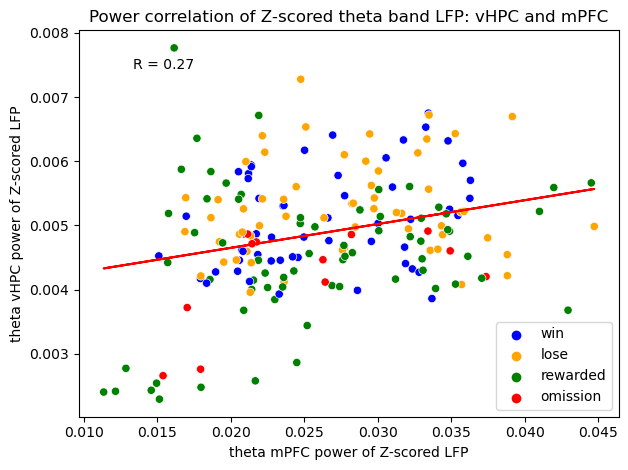

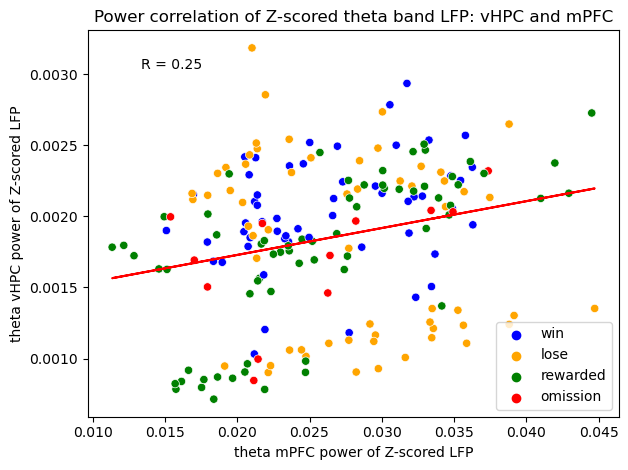

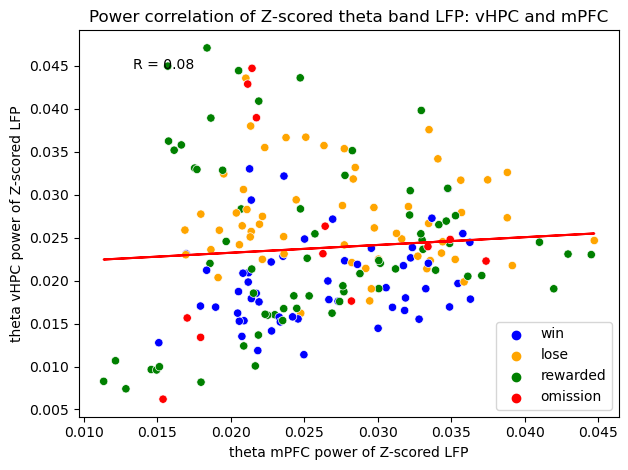

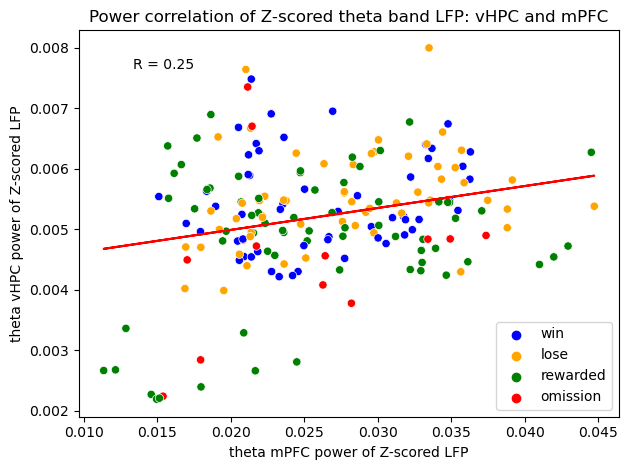

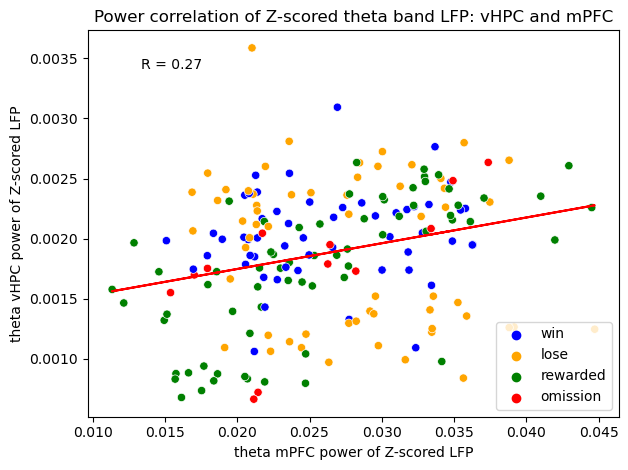

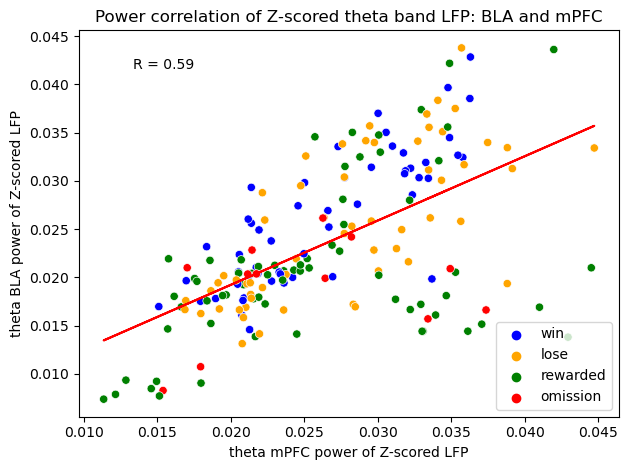

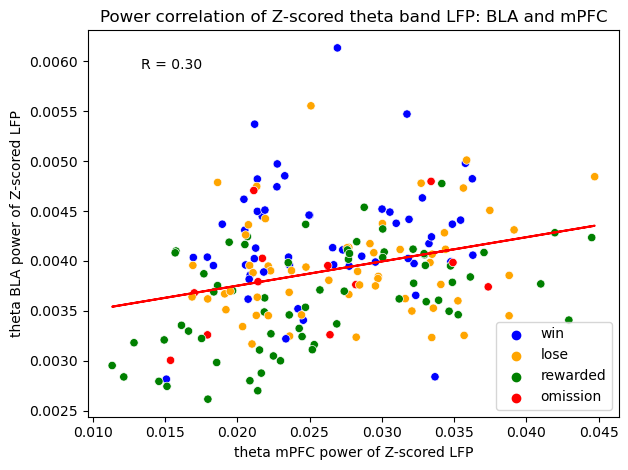

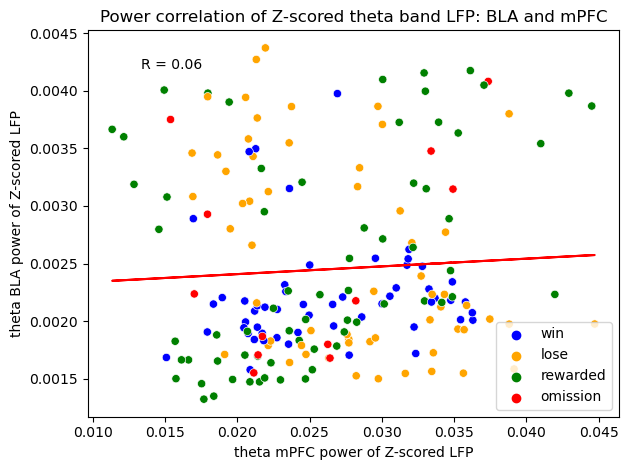

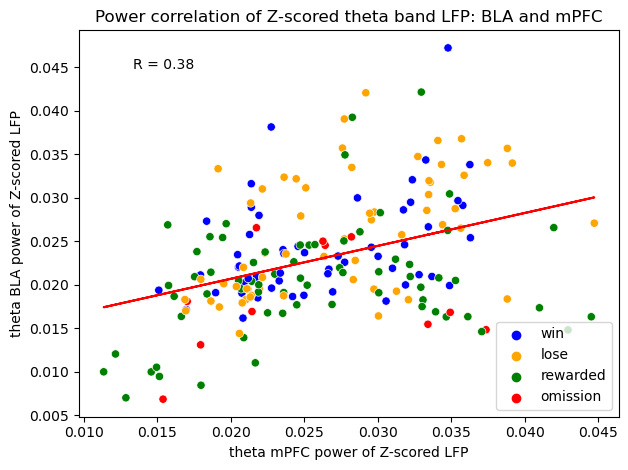

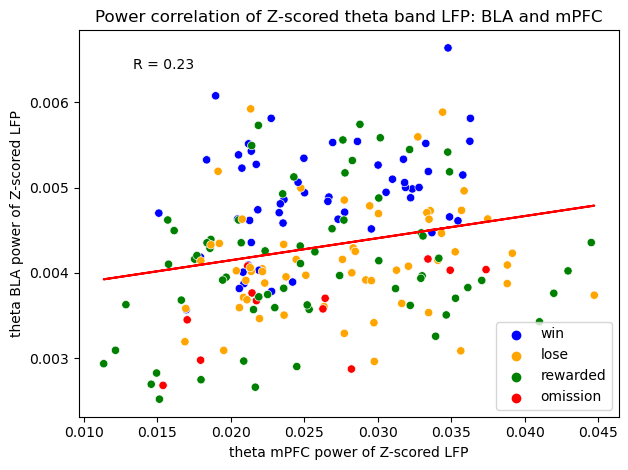

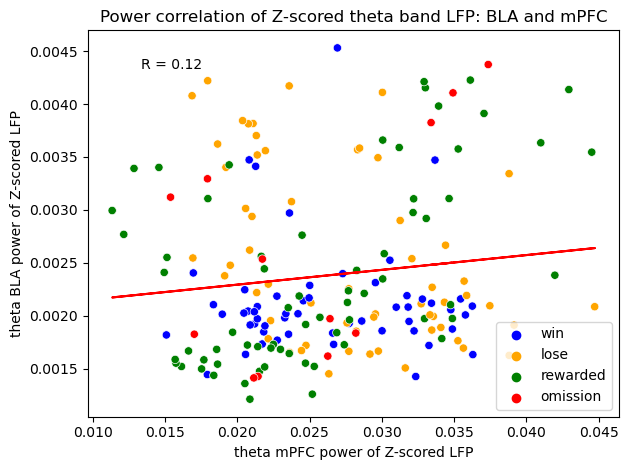

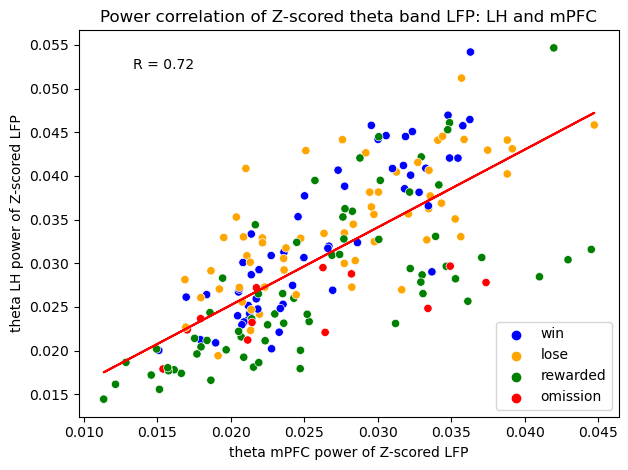

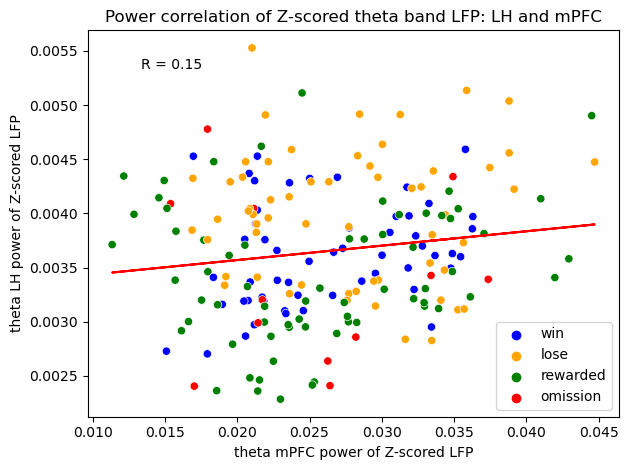

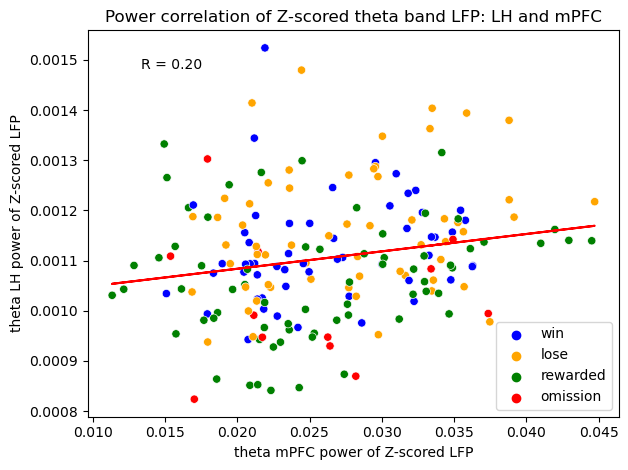

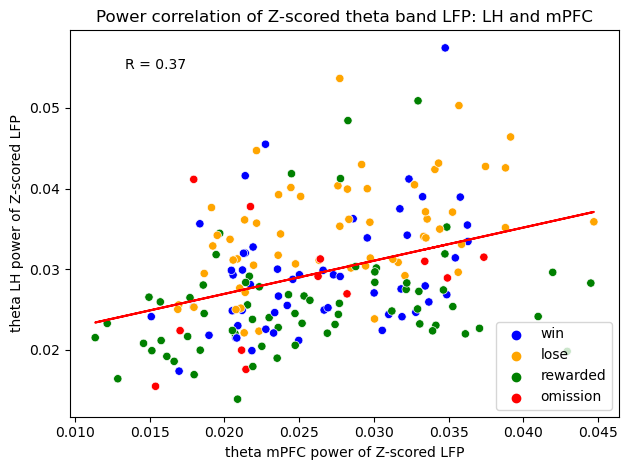

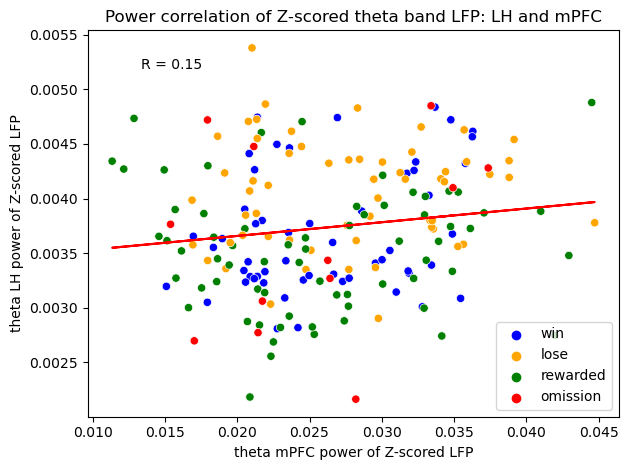

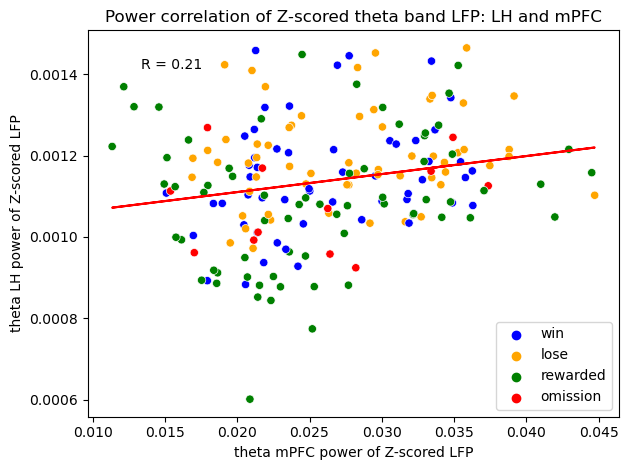

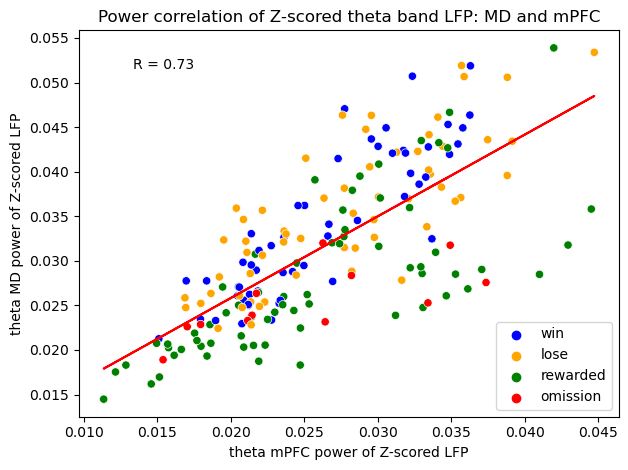

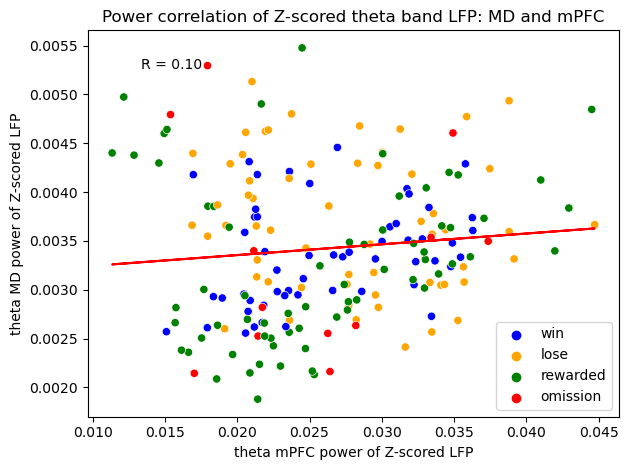

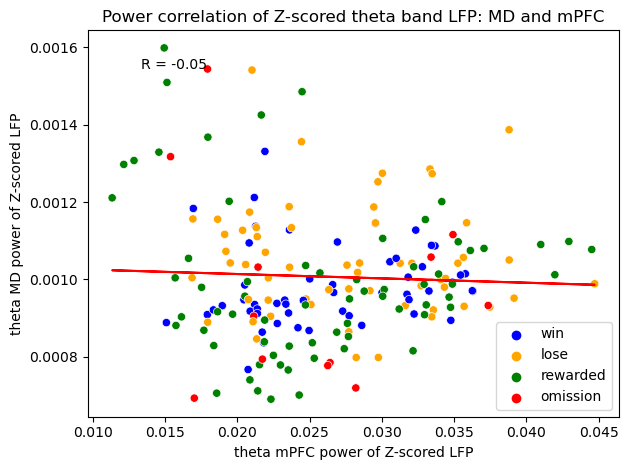

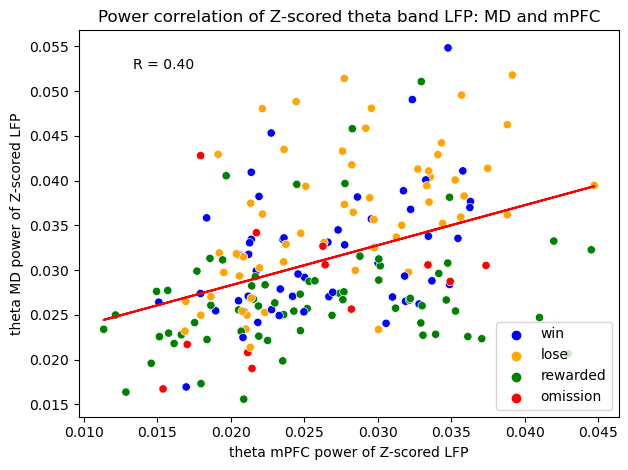

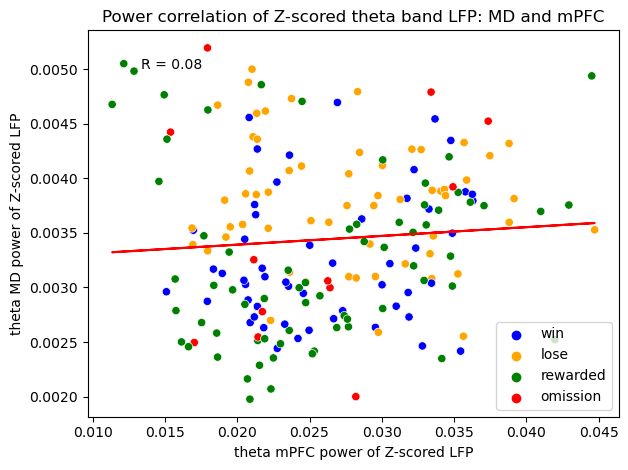

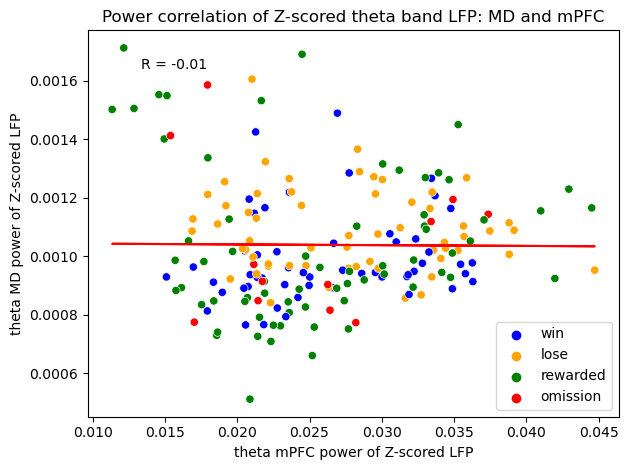

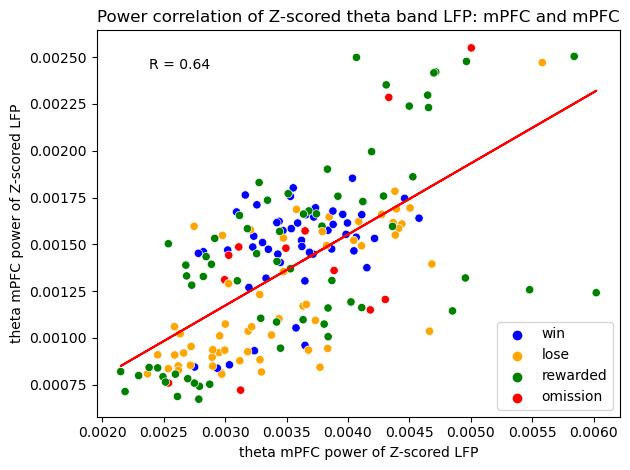

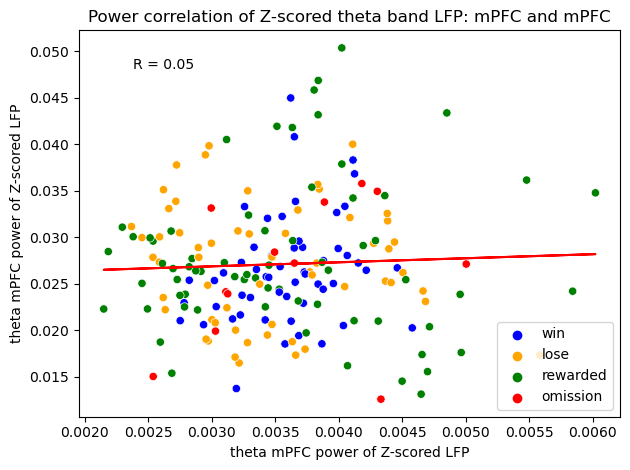

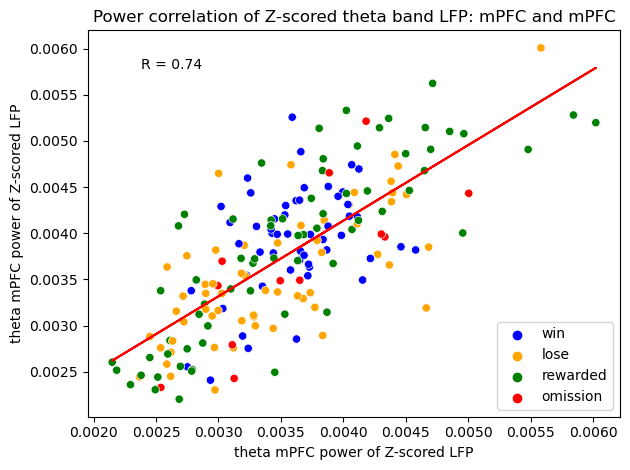

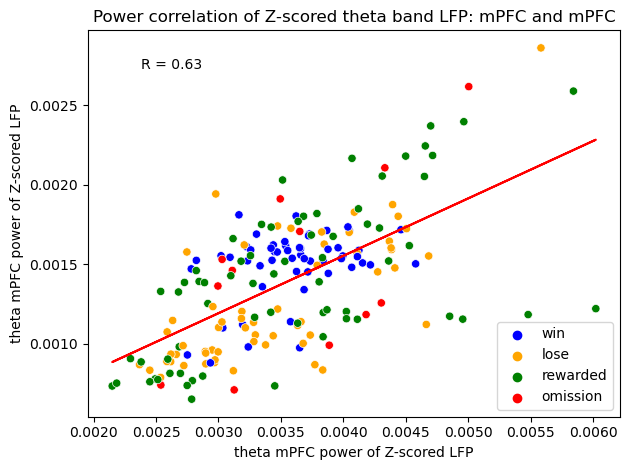

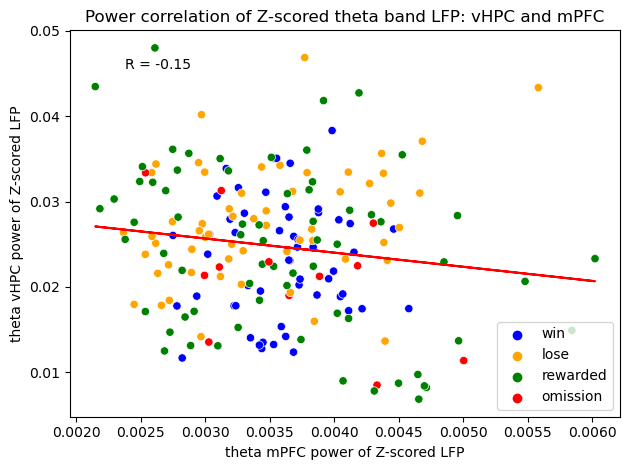

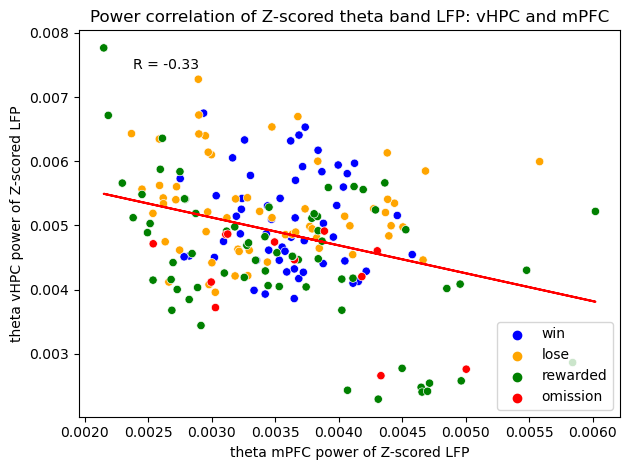

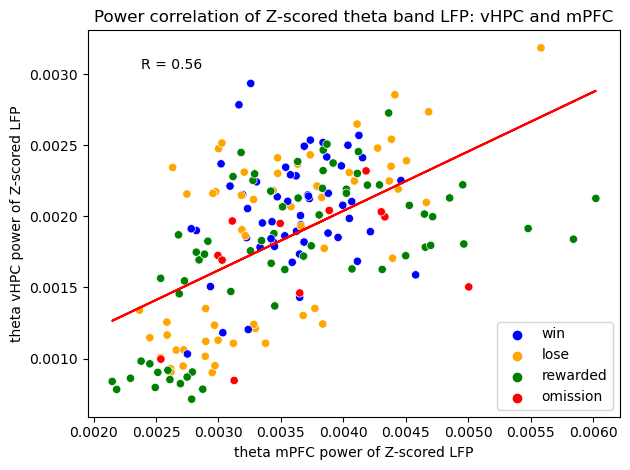

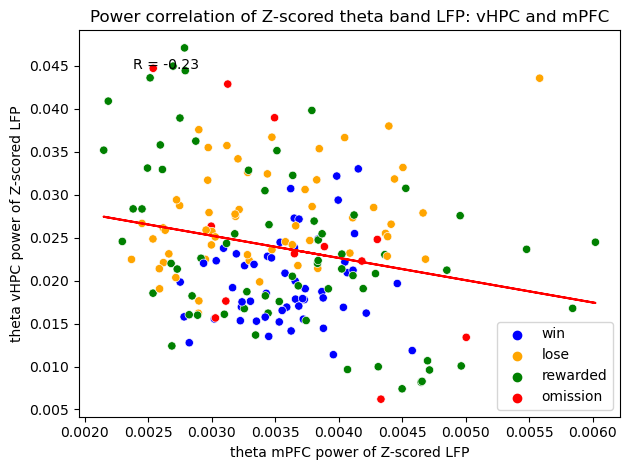

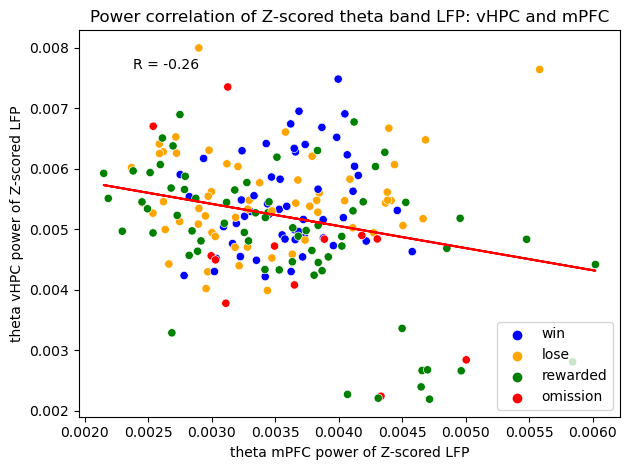

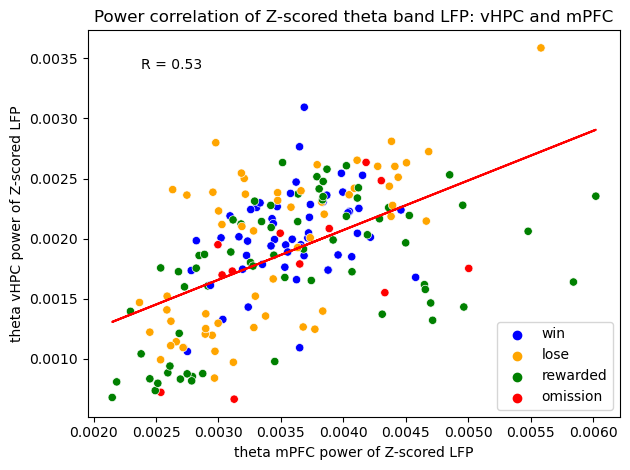

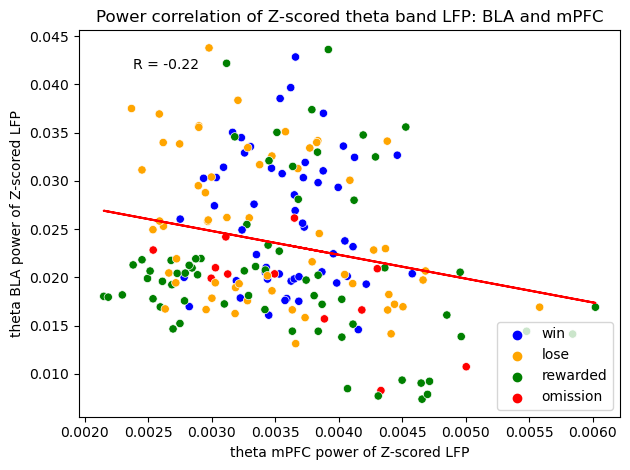

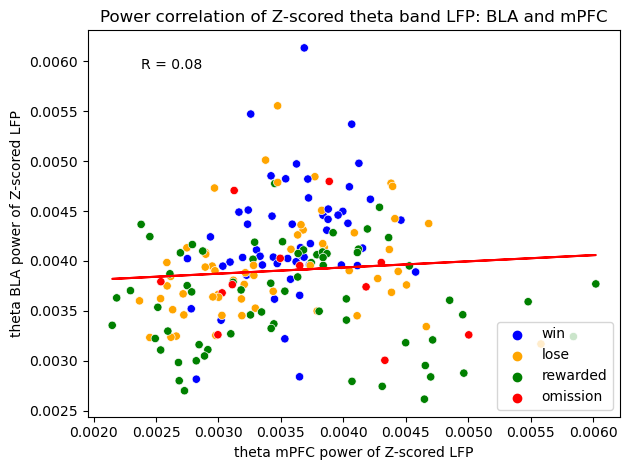

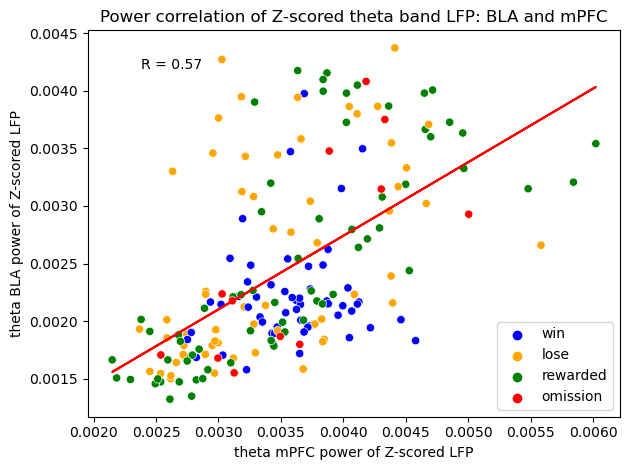

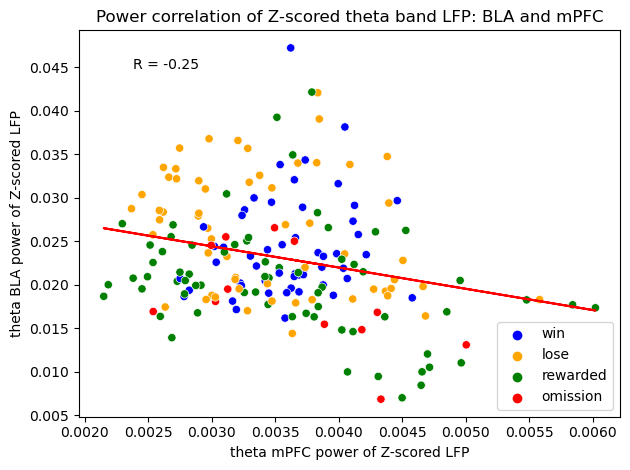

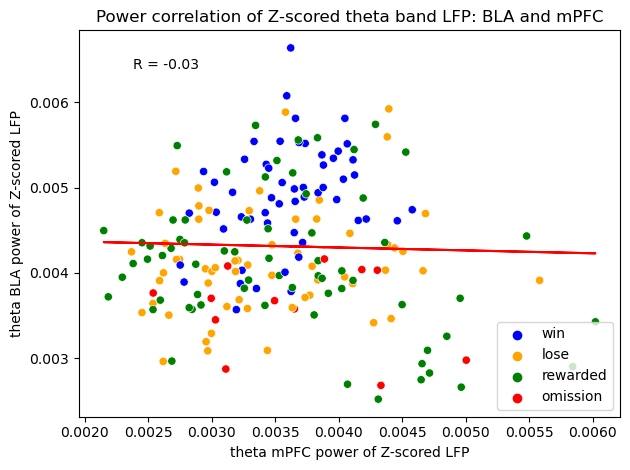

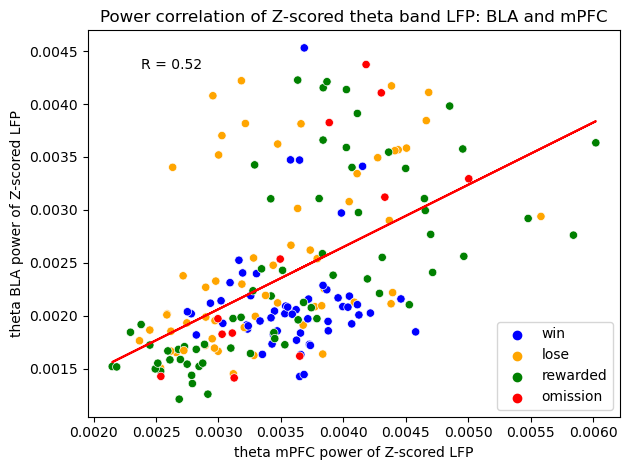

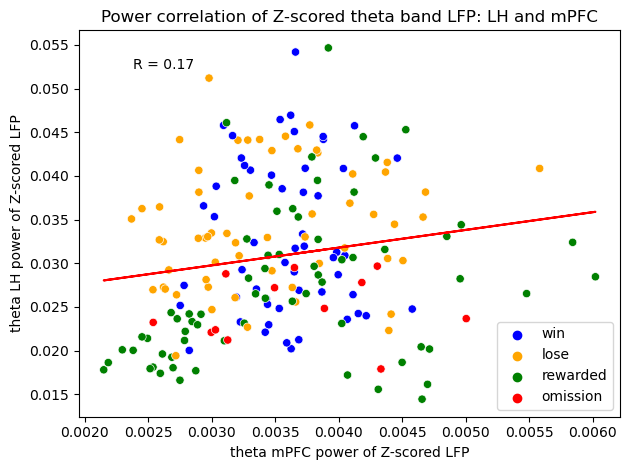

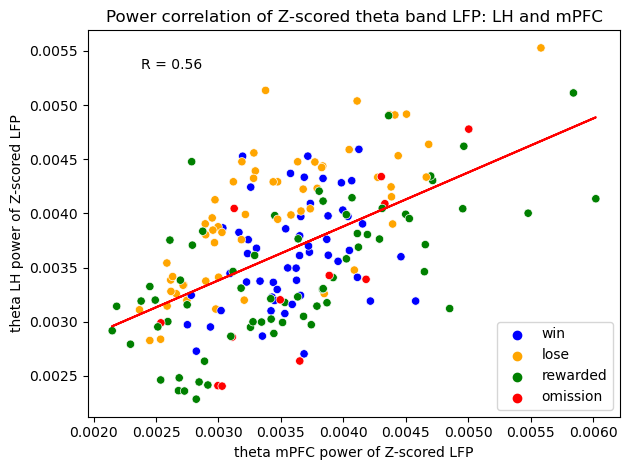

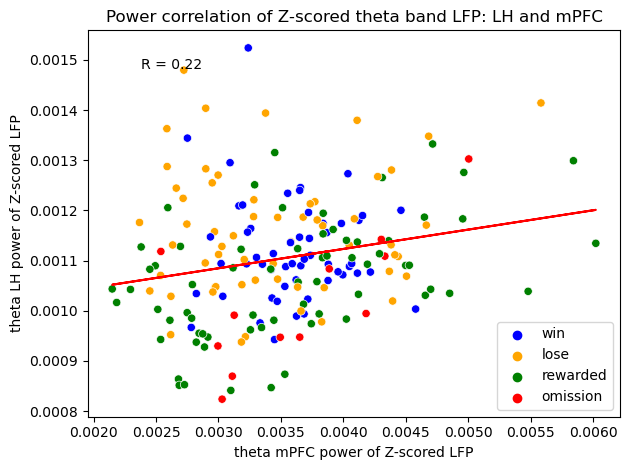

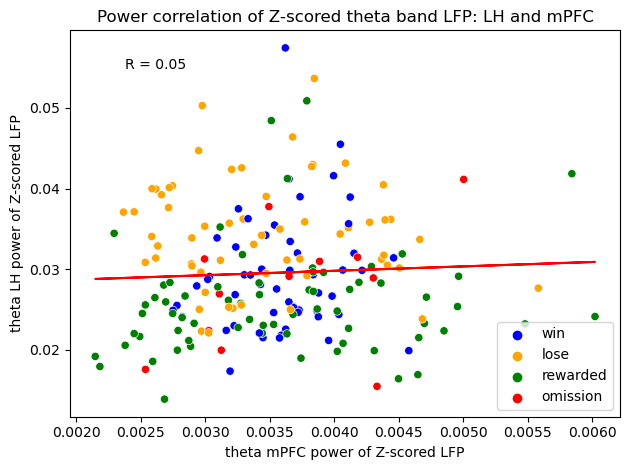

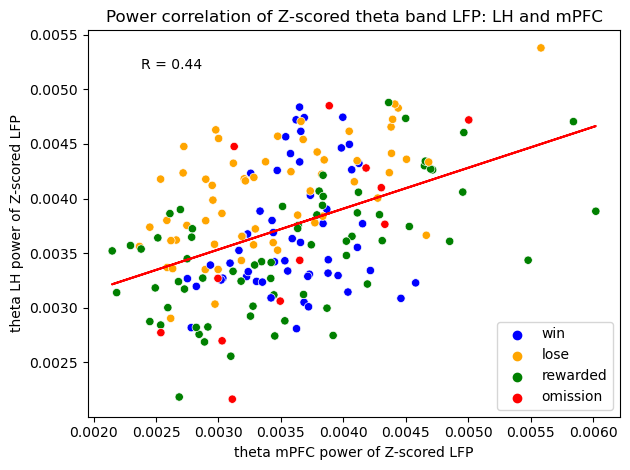

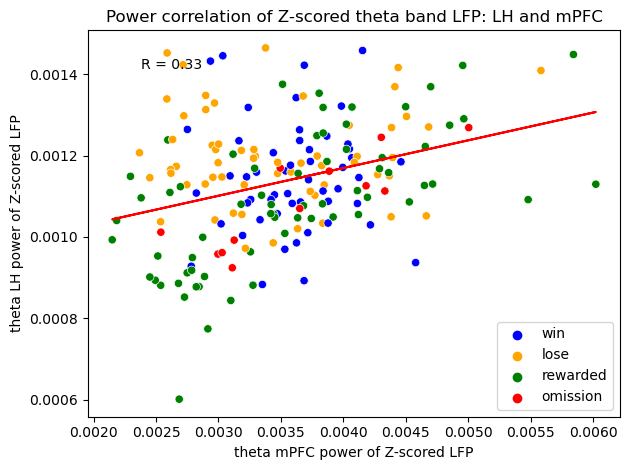

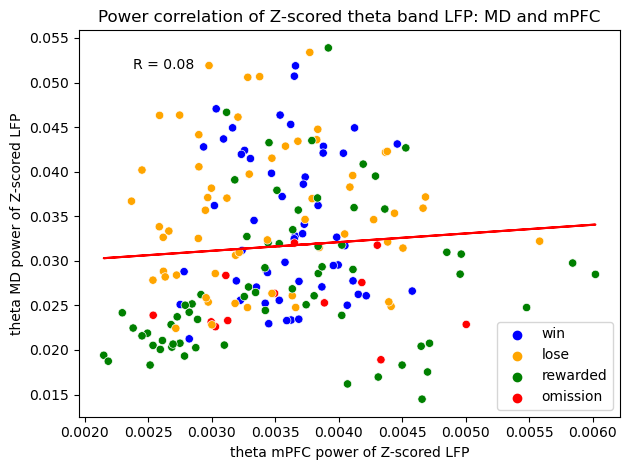

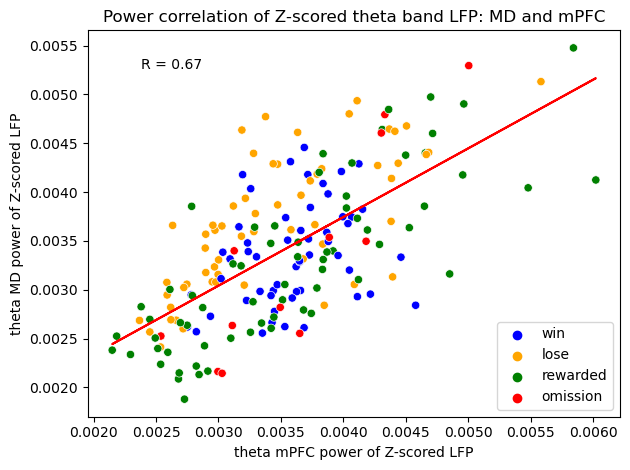

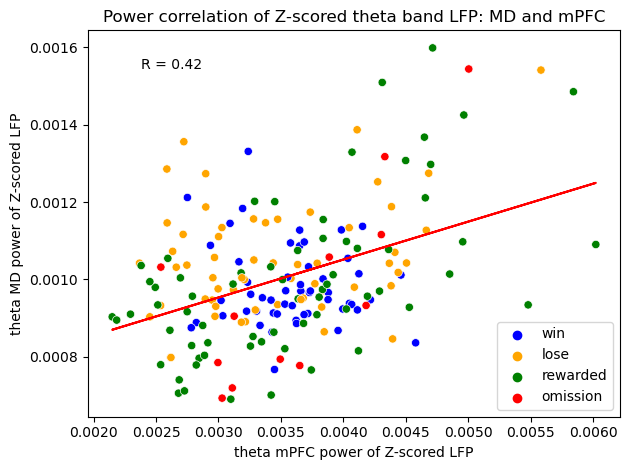

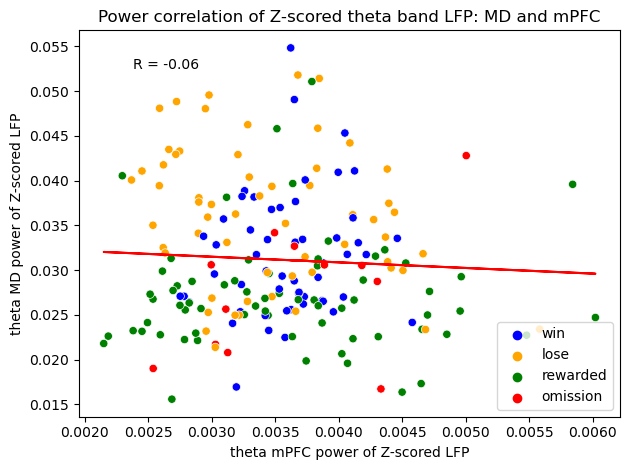

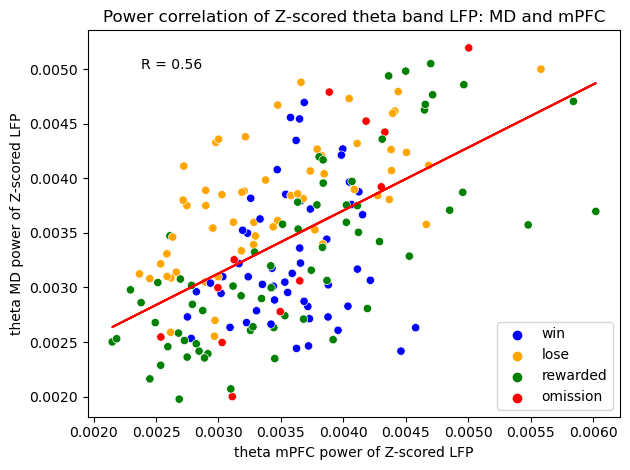

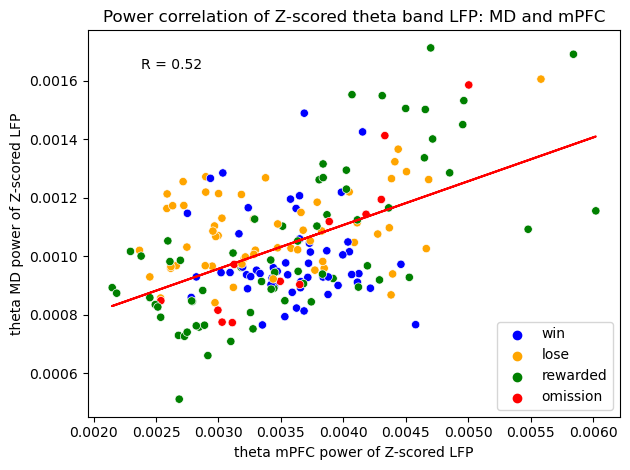

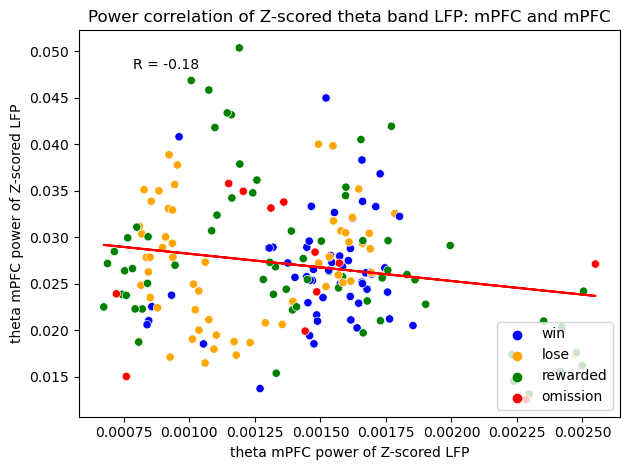

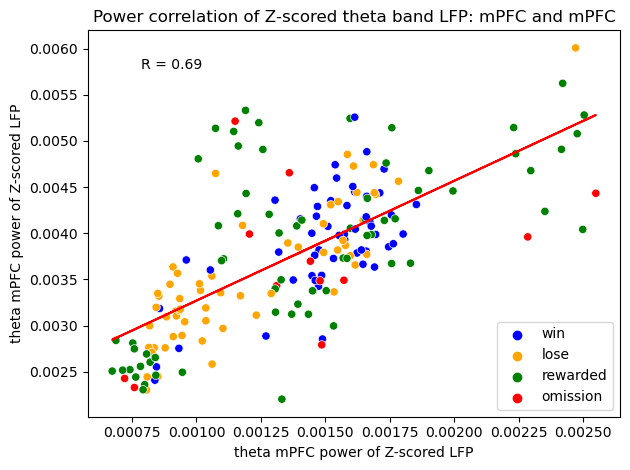

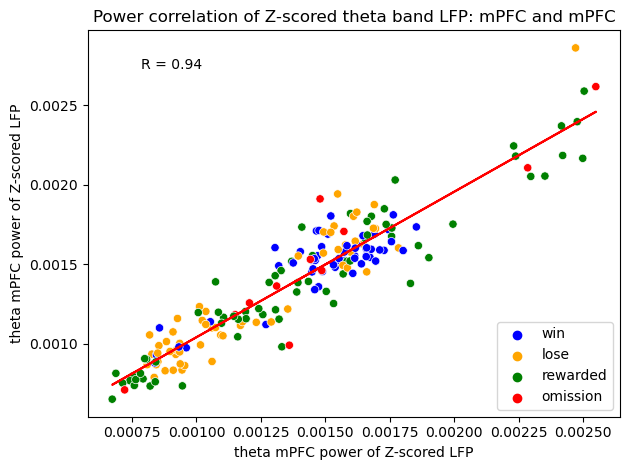

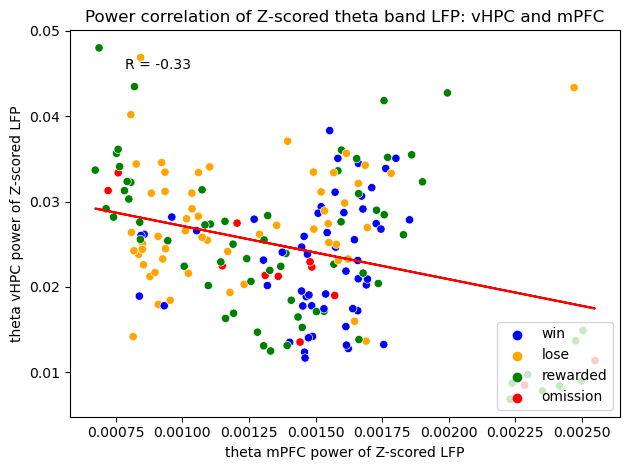

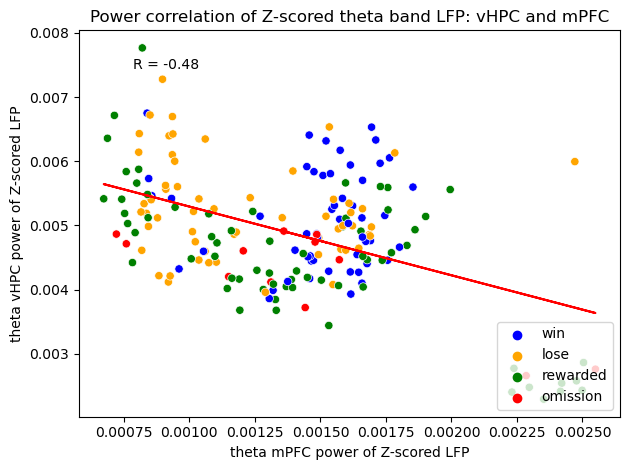

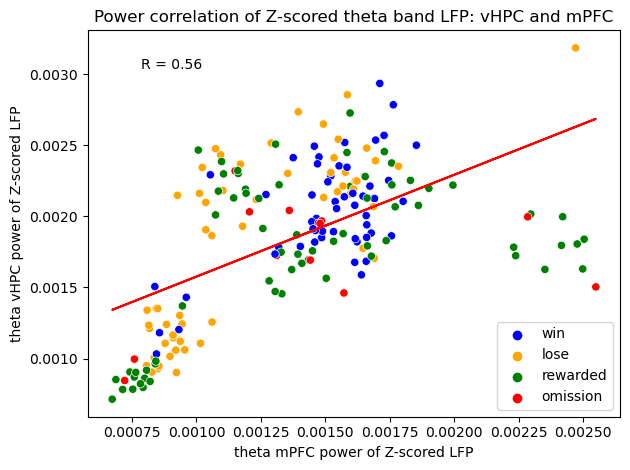

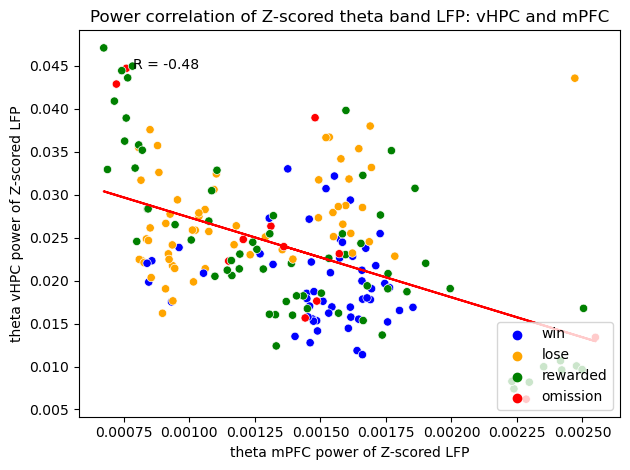

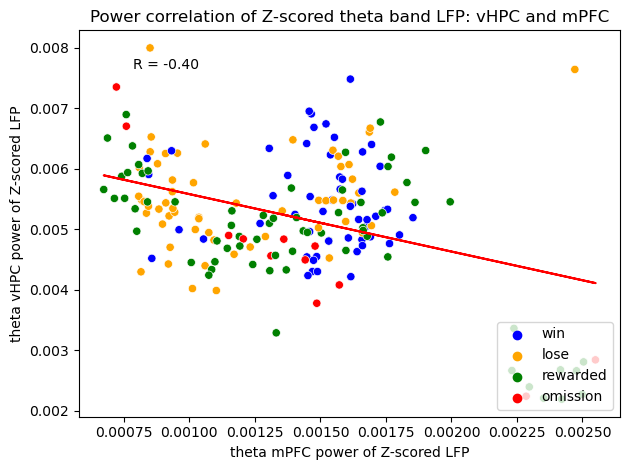

KeyboardInterrupt: 

In [127]:
for band in ALL_BANDS:
    for region_1, region_2 in band_to_power_correlation[band]["brain_region_pairs"]:
        region_1_basename = region_1.split("_")[0]
        region_2_basename = region_2.split("_")[0]
        x = filtered_df[region_1]
        y = filtered_df[region_2]
        
        # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        
        # Create a line of best fit using the slope and intercept
        line = slope * x + intercept
        
        # Create scatter plot
        sns.scatterplot(x=x, y=y, data=filtered_df, hue='trial_outcome', palette=BASELINE_OUTCOME_TO_COLOR)
        
        # Plot line of best fit
        plt.plot(x, line, color='red')
        
        # Add R² value to the plot
        plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
        
        # Add labels and legend
        plt.title("Power correlation of Z-scored {} band LFP: {} and {}".format(band, region_2_basename, region_1_basename))
        plt.xlabel('{} {} power of Z-scored LFP'.format(band, region_1_basename))
        plt.ylabel('{} {} power of Z-scored LFP'.format(band, region_2_basename))
        plt.legend(loc="lower right")
        plt.tight_layout()
        # plt.savefig("./proc/power_correlation/zscored/{}/all_condition_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, region_1_basename, region_2_basename, band))
        # Display the plot
        plt.show()




In [92]:
raise ValueError()

ValueError: 

In [93]:
FULL_LFP_TRACES = filtered_df

In [94]:
FULL_LFP_TRACES["trial_outcome"].unique()

array(['lose', 'win', 'rewarded', 'omission'], dtype=object)

In [96]:
for band in ALL_BANDS:
    band_df = filtered_df
    band_to_power_correlation[band]["region_pair_to_outcome_to_r2"] = defaultdict(nested_dict)
    for outcome in band_df["trial_outcome"].unique():
        outcome_df = band_df[band_df["trial_outcome"] == outcome]
        for region_1, region_2 in brain_region_pairs:
            region_1_basename = region_1.split("_")[0]
            region_2_basename = region_2.split("_")[0]
            
            x = outcome_df[region_1]
            y = outcome_df[region_2]
            
            # Perform linear regression to get the slope, intercept and r-value (correlation coefficient)
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            # Square the r value to get the r squared value
            r2_value = r_value**2
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["r"] = r_value
            band_to_power_correlation[band]["region_pair_to_outcome_to_r2"]["{}_{}".format(region_1.split("_")[0], region_2.split("_")[0])][outcome]["std"] = std_err
            
            # Create a line of best fit using the slope and intercept
            line = slope * x + intercept
            
            # Create scatter plot
            sns.scatterplot(x=x, y=y, data=outcome_df, hue='outcome_and_trial_or_baseline', palette=BASELINE_OUTCOME_TO_COLOR, style='outcome_and_trial_or_baseline', markers=['^', 'o'])
            
            # Plot line of best fit
            plt.plot(x, line, color='red')
            
            # Add R² value to the plot
            plt.text(0.1, 0.9, f'R = {r_value:.2f}', transform=plt.gca().transAxes)
            
            # Add labels and legend
            plt.title("Power Correlation of Z-scored {} LFP: {} and {}".format(band, region_2_basename, region_1_basename))
            plt.xlabel('{} {} Power of Z-scored LFP'.format(region_1_basename, band))
            plt.ylabel('{} {} Power of Z-scored LFP'.format(region_2_basename, band))
            plt.legend(loc="lower right")
            plt.tight_layout()
            plt.savefig("./proc/power_correlation/zscored/{}/{}_{}_{}_power_correlation_of_zscored_{}_lfp.png".format(band, outcome, region_1_basename, region_2_basename, band))
            # Display the plot
            plt.show()

NameError: name 'brain_region_pairs' is not defined

In [ ]:
for band in ALL_BANDS:
    # Convert the nested dictionary to a DataFrame
    data = []
    for group_name, group_data in band_to_power_correlation[band]['region_pair_to_outcome_to_r2'].items():
        for bar_name, bar_dict in group_data.items():
            data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
    df = pd.DataFrame(data)
    
    # Create the bar plot using seaborn
    # sns.catplot(
    #     data=df, 
    #     x='Group', 
    #     y='r2', 
    #     hue='Bar', 
    #     kind='bar', 
    #     height=4, 
    #     aspect=2,
    #     legend=False,
    #     # yerr=df['std'].values,  # This line adds the SEM bars
    #     # capsize=0.1  # This line adds caps on the error bars
    # )
    
    # Create barplot
    ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)
    
    # Adding error bars
    groups = df['Group'].unique()
    bars_per_group = df['Bar'].nunique()
    bar_width = 0.8 / bars_per_group
    x_positions = []
    
    for i, group in enumerate(groups):
        num_bars = df[df['Group'] == group].shape[0]
        group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
        x_positions.extend(group_positions)
    
    for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
        plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)
    
    
    plt.xticks(rotation=90)
    plt.xlabel("Brain region pairs")
    plt.ylabel("Power correlation r")
    plt.legend(title="Trial Conditions")
    plt.title("{} Power correlations".format(band))
    plt.tight_layout()
    plt.grid()
    
    plt.savefig("./proc/power_correlation/zscored/all_zscored_{}_lfp_power_correlation.png".format(band))
    # Show the plot
    plt.show()

In [ ]:

# Convert the nested dictionary to a DataFrame
data = []
for group_name, group_data in region_pair_to_outcome_to_r2.items():
    for bar_name, bar_dict in group_data.items():
        data.append({"Group": group_name, "Bar": bar_name, "r": bar_dict["r"], "std": bar_dict["std"]})
df = pd.DataFrame(data)

# Create the bar plot using seaborn
# sns.catplot(
#     data=df, 
#     x='Group', 
#     y='r2', 
#     hue='Bar', 
#     kind='bar', 
#     height=4, 
#     aspect=2,
#     legend=False,
#     # yerr=df['std'].values,  # This line adds the SEM bars
#     # capsize=0.1  # This line adds caps on the error bars
# )

# Create barplot
ax = sns.barplot(x='Group', y='r', hue='Bar', data=df, ci=None)

# Adding error bars
groups = df['Group'].unique()
bars_per_group = df['Bar'].nunique()
bar_width = 0.8 / bars_per_group
x_positions = []

for i, group in enumerate(groups):
    num_bars = df[df['Group'] == group].shape[0]
    group_positions = np.linspace(i - bar_width*(num_bars-1)/2, i + bar_width*(num_bars-1)/2, num_bars)
    x_positions.extend(group_positions)

for i, (r2, sem) in enumerate(zip(df['r'], df['std'])):
    plt.errorbar(x_positions[i], r2, yerr=sem, fmt='none', color='black', capsize=5)


plt.xticks(rotation=90)
plt.xlabel("Brain region pairs")
plt.ylabel("Power correlation r")
plt.legend(title="Trial Conditions")
plt.title("Power correlations")
plt.tight_layout()
plt.grid()

plt.savefig("./proc/power_correlation/zscored/all_zscored_lfp_power_correlation.png")
# Show the plot
plt.show()